## Bollinger Bands 布林带指标

运用统计学原理， 计算出股价标准差及置信区间， 从而确定未来走势以及波动范围。

计算公式： 

中轨线 = (N-1)MA

上轨线 = 中轨线 + K* MD (MD 为标准差）

下轨线 = 中轨线 - K* MD (MD 为标准差）


# 策略思想

与CCI相似，+-100 即这里的上下轨；

当股价<下轨时， 表明股价已经进入一个非常态区间，超卖区间， 因此
当股价从下轨之下突破到下轨之上时，开多仓； 
***
当股价>上轨时， 表明股价已经进入另外一个非常态区间，超买区间， 因此
当股价从上轨之上下跌到上轨之下时，开空仓；

Note: 向量填充 VS 循环法：
    
以循环遍历的思想设计策略，适合更为复杂的策略构建。


In [1]:
import numpy as np
import pandas as pd
import talib as ta
import tushare as ts

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# 确保‘-’号显示正常
mpl.rcParams['axes.unicode_minus']=False
# 确保中文显示正常
mpl.rcParams['font.sans-serif'] = ['SimHei']  

import warnings; warnings.simplefilter('ignore') #忽略可能会出现的警告信息，警告并不是错误，可以忽略；

### 1. 数据准备

In [2]:
# 获取数据
stock_index = ts.get_k_data('hs300', '2017-08-17', '2020-08-17')
# 将date设置为index
stock_index['date'] = pd.to_datetime(stock_index['date'])
stock_index.set_index('date', inplace = True)
stock_index.head()

,open,close,high,low,volume,code
date,,,,,,
2017-08-17,3707.07,3721.28,3722.62,3704.41,108656251.0,hs300
2017-08-18,3707.19,3724.67,3733.49,3700.41,96561705.0,hs300
2017-08-21,3731.84,3740.99,3744.26,3728.62,100313073.0,hs300
2017-08-22,3745.75,3752.30,3758.29,3734.56,100292856.0,hs300
2017-08-23,3747.61,3756.09,3772.46,3741.72,104961573.0,hs300


In [3]:
stock_index.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 2017-08-17 to 2020-08-14
Data columns (total 6 columns):
open      729 non-null float64
close     729 non-null float64
high      729 non-null float64
low       729 non-null float64
volume    729 non-null float64
code      729 non-null object
dtypes: float64(5), object(1)
memory usage: 39.9+ KB


In [4]:
# 计算bollinger线
stock_index['upper'], stock_index['middle'], stock_index['lower'] = ta.BBANDS(np.asarray(stock_index['close']),timeperiod=20, nbdevup=1.8, nbdevdn=1.5, matype=0)

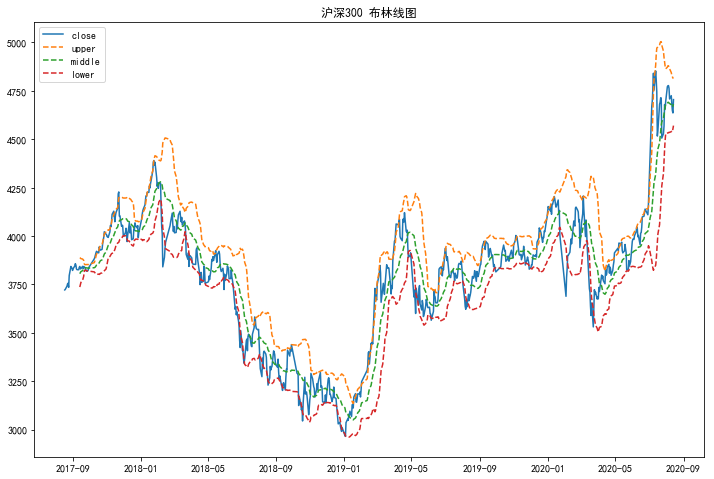

In [5]:
# 绘图
fig = plt.figure(figsize = (12,8))
plt.plot(stock_index['close'])
plt.plot(stock_index['upper'], linestyle='--')
plt.plot(stock_index['middle'], linestyle='--')
plt.plot(stock_index['lower'], linestyle='--')
plt.title('沪深300 布林线图')
plt.legend()

### 2.1 交易信号和持仓信号计算(分开计算)

In [6]:
# 计算昨日数据
stock_index['yes_close'] = stock_index['close'].shift(1)
stock_index['yes_lower'] = stock_index['lower'].shift(1)
stock_index['yes_upper'] = stock_index['upper'].shift(1)
# 计算前天数据
stock_index['daybeforeyes_close'] = stock_index['close'].shift(2)
stock_index['daybeforeyes_lower'] = stock_index['lower'].shift(2)
stock_index['daybeforeyes_upper'] = stock_index['upper'].shift(2)

In [7]:
# 计算交易信号
# 开多信号:前天收盘价低于下轨，昨日收盘价高于下轨
stock_index['signal'] = np.where(np.logical_and(
                             stock_index['daybeforeyes_close'] < stock_index['daybeforeyes_lower'],
                             stock_index['yes_close'] > stock_index['yes_lower']),
                             1, 0)
# 开空信号：前天日收盘价高于上轨，昨日收盘价低于上轨
stock_index['signal'] = np.where((stock_index['daybeforeyes_close'] > stock_index['daybeforeyes_upper']) &
                                 (stock_index['yes_close'] < stock_index['yes_upper']),
                             -1, stock_index['signal'])

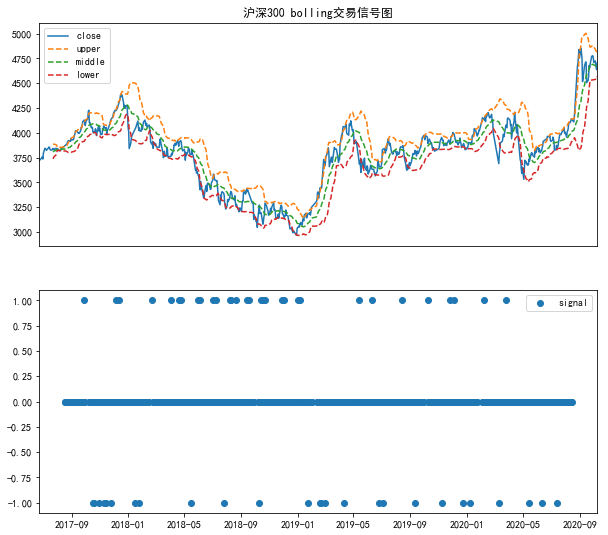

In [8]:
# 绘制交易信号图
plt.subplot(2,1,1)
plt.title('沪深300 bolling交易信号图')
plt.gca().axes.get_xaxis().set_visible(False)
stock_index['close'].plot(figsize=(10,10))
plt.plot(stock_index['upper'], linestyle='--')
plt.plot(stock_index['middle'], linestyle='--')
plt.plot(stock_index['lower'], linestyle='--')
plt.legend()

plt.subplot(2,1,2)
plt.plot(stock_index['signal'], marker='o', linestyle='')
plt.legend()

# plt.show()

# 使用position标记持仓情况，全新的循环法思路；

In [9]:
position = 0
# 对每个交易日进行循环    
for item in stock_index.iterrows():   #逐行遍历；返回的这个item其实一个元组，（label，series）
    # 判断交易信号
    if item[1]['signal'] == 1:
        # 交易信号为1，则记录仓位为1，持有多仓；
        position = 1
    elif item[1]['signal'] == -1:
        # 交易信号为-1， 则记录仓位为-1，持有空仓；
        position = -1
    else:
        pass     #啥都不做；
    # 记录每日持仓情况
    stock_index.loc[item[0], 'position'] = position      #自动往下填充的就是上一个产生的交易信号；关键；

In [10]:
# 使用position标记持仓情况，全新的循环法思路；另外一种方法；
position = 0
# 对每个交易日进行循环    
for i, item in stock_index.iterrows():   #逐行遍历；这里item就是一个Series； unpacked
    # 判断交易信号
    if item['signal'] == 1:
        # 交易信号为1，则记录仓位为1，持有多仓；
        position = 1
    elif item['signal'] == -1:
        # 交易信号为-1， 则记录仓位为-1，持有空仓；
        position = -1
    else:
        pass
    # 记录每日持仓情况
    stock_index.loc[i, 'position'] = position      #在DataFrame中自动往下填充的就是上一个产生的交易信号；关键；

Text(0.5, 0.98, '沪深300 bolling持仓情况')

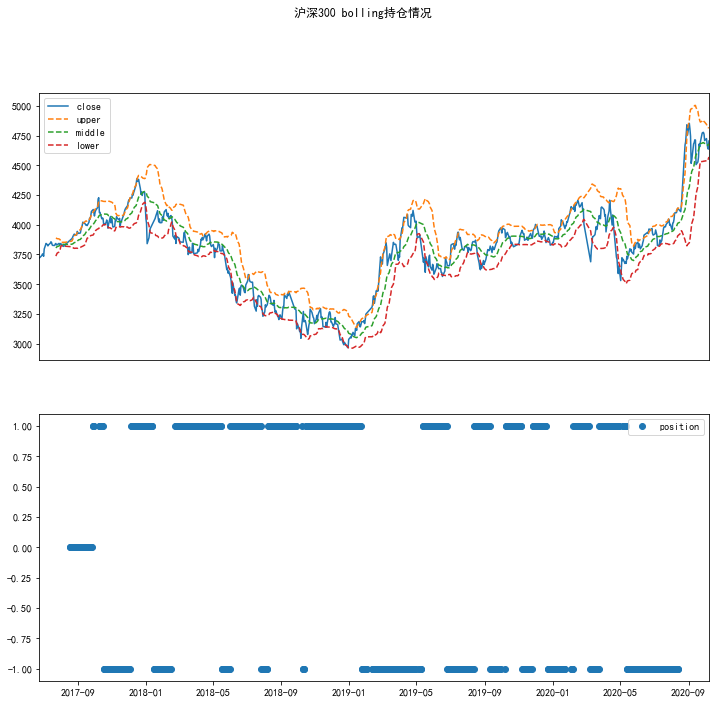

In [11]:
# 绘制持仓情况图
plt.subplot(2,1,1)
plt.gca().axes.get_xaxis().set_visible(False)
stock_index['close'].plot(figsize=(12,12))
plt.plot(stock_index['upper'], linestyle='--')
plt.plot(stock_index['middle'], linestyle='--')
plt.plot(stock_index['lower'], linestyle='--')
plt.legend()

plt.subplot(2,1,2)
plt.plot(stock_index['position'], marker='o', linestyle='')
plt.legend()
plt.suptitle('沪深300 bolling持仓情况')

### 3. 计算策略收益及可视化

In [12]:
# 计算股票每日收益率
stock_index['pct_change'] = stock_index['close'].pct_change()
# 计算股票的累积收益率
stock_index['return'] = (stock_index['pct_change'] + 1).cumprod()
# 计算策略每日收益率
stock_index['strategy_return'] = stock_index['position'] * stock_index['pct_change']
# 计算策略累积收益率
stock_index['cum_strategy_return'] = (stock_index['strategy_return'] + 1).cumprod()

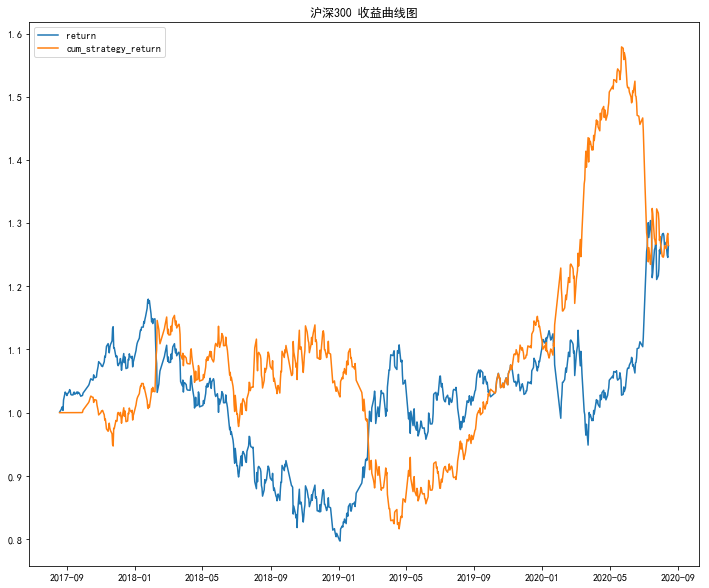

In [13]:
# 绘图
fig = plt.figure(figsize = (12,10))
plt.plot(stock_index['return'])
plt.plot(stock_index['cum_strategy_return'])
plt.title('沪深300 收益曲线图')
plt.legend(loc='upper left')
plt.show()


策略从2019-5到2020-5月见表现出色非常出色， 1.8上轨SD， 1.5下轨SD的参数似乎非常准确的抓住了这段时间内的买卖节点，
从而尽管股价在震荡调整但策略持续盈利。然而2019-01 到2019-05以及2020-05到2020-09 时间内策略有30%+ 的较大回撤。
